* 使用 Xception 将先前的结果再次复现一遍
* 再对两个结果进行简单的加权融合

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# 导入数据
df_train = pd.read_csv('../../raw/train/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [4]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

In [21]:
# 加载数据
cur_class = classes[3]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

sleeve_length_labels: 17285


,image_id,class,label
0,Images/sleeve_length_labels/f5c414bda8a9bb97f6...,sleeve_length_labels,nnnnnnmym
1,Images/sleeve_length_labels/ffeef43a34d68b2a47...,sleeve_length_labels,nnynnnnnn
2,Images/sleeve_length_labels/4be61ca727ad25645e...,sleeve_length_labels,nnnnnnmmy
3,Images/sleeve_length_labels/b9d69a26db06295bfa...,sleeve_length_labels,nnnynnnnn
4,Images/sleeve_length_labels/fb7c3a0181d538b52e...,sleeve_length_labels,nnnnnnynn


In [22]:
df_collar = pd.read_csv('../../raw/result/collar_0601a.csv', header=None)
df_neckline = pd.read_csv('../../raw/result/neckline_0601a.csv', header=None)
df_skirt = pd.read_csv('../../raw/result/skirt_0601a.csv', header=None)
df_sleeve = pd.read_csv('../../raw/result/sleeve_0601a.csv', header=None)
df_neck = pd.read_csv('../../raw/result/neck_0601_xcept_incept_1.csv', header=None)
df_coat = pd.read_csv('../../raw/result/coat_0601_xcept_incept_1.csv', header=None)
df_lapel = pd.read_csv('../../raw/result/lapel_0601a.csv', header=None)
df_pant = pd.read_csv('../../raw/result/pant_0601a.csv', header=None)

In [24]:
len(df_sleeve)/len(df_load)/2

0.33827017645357244

In [6]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

In [7]:
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('../../raw/base/{0}'.format(df_load['image_id'][i])), (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 8392/8392 [01:09<00:00, 119.94it/s]


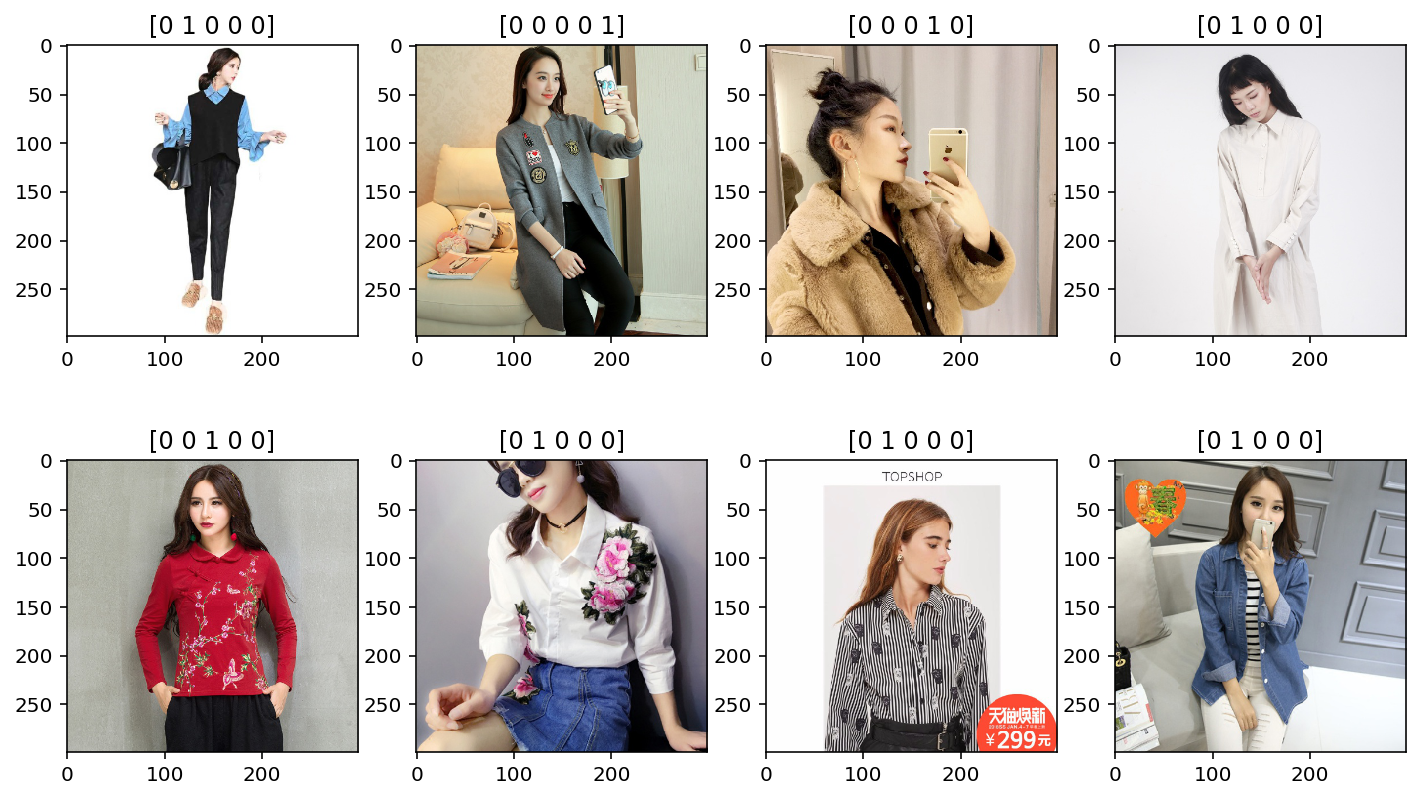

In [8]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

In [14]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
import keras

In [12]:
cnn_model = Xception(include_top=False, input_shape=(width, width, 3), weights='imagenet')

In [15]:
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [17]:
# 划分训练/测试集
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=42)
X_train.shape, y_train.shape

((7384, 299, 299, 3), (7384, 5))

In [19]:
# Compile the model
adam = Adam(lr=0.001) 

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
epochs = 32
batch_size = 32

In [21]:
datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening = False, # apply ZCA whitening
        rotation_range = 12, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # randomly zoom image
        width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1, # randomly shift images vertivally (fraction of total heigth)
        horizontal_flip = True, # randomly flip images
        vertical_flip = False,
        shear_range = 0.1,
        fill_mode = 'constant',
        cval = 0)

datagen.fit(X_train)

In [22]:
prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='./models/{0}.best.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, mode='val_acc')

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=3), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
KeyboardInterrupt
